In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import pointpats 
from pointpats import PointPattern
import shapely
from shapely.wkt import loads  
from shapely.geometry import Point
from libpysal.cg import shapely_ext
from pointpats import PoissonPointProcess as ppp_csr
from pointpats import window
from pointpats.window import poly_from_bbox, as_window, Window, to_ccf
import pointpats.quadrat_statistics as qs
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
import pysal as ps #derive spatial geometry features 
import libpysal as lps


# to add basemap
!pip install contextily
import contextily
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster

from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from libpysal import weights
from pysal.explore import esda
from splot import esda as esdaplot  #for an easy way to plot cluster mapb
import numba 

import warnings
warnings.simplefilter('ignore') 

/opt/conda/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
banks_df = pd.read_csv('geolytix_uk_banks.csv') #read csv

In [3]:
banks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11660 entries, 0 to 11659
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               11660 non-null  int64  
 1   brand_full       11660 non-null  object 
 2   brand_short      11660 non-null  object 
 3   branch_name      11540 non-null  object 
 4   branch_type      11660 non-null  object 
 5   add_one          10846 non-null  object 
 6   add_two          4137 non-null   object 
 7   suburb           8021 non-null   object 
 8   town             11235 non-null  object 
 9   region           10622 non-null  object 
 10  postcode         11484 non-null  object 
 11  long_wgs84       11660 non-null  float64
 12  lat_wgs84        11660 non-null  float64
 13  hours_monday     5882 non-null   object 
 14  hours_tuesday    5792 non-null   object 
 15  hours_wednesday  5684 non-null   object 
 16  hours_thursday   5692 non-null   object 
 17  hours_friday

In [4]:
#data cleaning
duplicate_rows = banks_df.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

Number of duplicate rows: 0


In [5]:
#define xy coordinates, create geometry object, create gdf of csv
geometry = [Point(xy) for xy in zip(banks_df['long_wgs84'], banks_df['lat_wgs84'])]
banks_gdf_csv = gpd.GeoDataFrame(banks_df, geometry=geometry)

In [6]:
#Set the Coordinate Reference System (CRS)
banks_gdf_csv.set_crs(epsg=4326, inplace=True)  # WGS84 CRS

#Save as shapefile
banks_gdf = "geolytix_uk_banks.shp" 
banks_gdf_csv.to_file(banks_gdf, driver='ESRI Shapefile')

In [7]:
banks_gdf = gpd.read_file("geolytix_uk_banks.shp") #read created shp

In [8]:
banks_gdf.head()

,id,brand_full,brand_shor,branch_nam,branch_typ,add_one,add_two,suburb,town,region,...,hours_thur,hours_frid,hours_satu,trading_ho,status,close_mont,close_year,open_year,po_dist,geometry
0,1,Allied Irish Bank,AIB,Birmingham,Branch,Birmingham City Office,61 Temple Row,Central Birmingham,Birmingham,West Midlands,...,09:00-17:00,09:00-16:45,None,38.75,Open,NaN,NaN,NaN,298,POINT (-1.89857 52.48045)
1,2,Allied Irish Bank,AIB,Brighton,Branch,20/22 Marlborough Place,Brighton,Central Brighton,Brighton,South East,...,09:00-17:00,09:00-16:45,None,38.75,Open,NaN,NaN,NaN,449,POINT (-0.13689 50.82460)
2,3,Allied Irish Bank,AIB,Clifton,Branch,19 Whiteladies Road,Clifton,Cotham,Bristol,South West,...,09:00-17:00,09:00-16:45,None,38.75,Open,NaN,NaN,NaN,511,POINT (-2.60870 51.45976)
3,4,Allied Irish Bank,AIB,High St Belfast,Branch,None,None,Central Belfast,Belfast,Northern Ireland,...,None,None,None,NaN,Closed,8.0,2017.0,NaN,54,POINT (-5.92669 54.59992)
4,5,Allied Irish Bank,AIB,Belfast,Branch,"Donegall Square North, Town Centre, City Of Be...",None,Central Belfast,Belfast,Northern Ireland,...,None,None,None,NaN,Open,NaN,NaN,NaN,166,POINT (-5.93087 54.59725)


In [9]:
#Prepare data

# open UK LAD polygon shapefile using libpysal
lads = lps.io.open ('LAD_MAY_2024_UK_BUC.shp') 

# define the polygon shapes from UK LAD data
polys = [shp for shp in lads]

# Create the exterior polygons for UK from the union of the polygon shapes using unary union
boundary = shapely_ext.unary_union(polys)

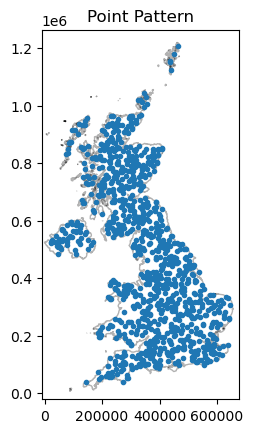

In [10]:
#Generate CSR Point Pattern

# generate 1000 points following csr process
# define its region boundary as UK boundary
pp = ppp_csr(as_window(boundary), 1000, 1, asPP=True).realizations[0] 

# Realizations at index 0 means first realised (simulated) point pattern
# plot point pattern out
pp.plot(window=True)

In [11]:
#create subset of gdf for closed (status) branches (branch type)
closed_branches = banks_gdf[(banks_gdf['branch_typ'] == 'Branch') & (banks_gdf['status'] == 'Closed')][['id', 'brand_full', 'brand_shor', 'branch_typ', 'region', 'postcode', 'long_wgs84', 'lat_wgs84', 'status', 'close_year', 'po_dist', 'geometry']]

In [12]:
closed_branches.head()

,id,brand_full,brand_shor,branch_typ,region,postcode,long_wgs84,lat_wgs84,status,close_year,po_dist,geometry
3,4,Allied Irish Bank,AIB,Branch,Northern Ireland,BT1 2AL,-5.926691,54.599923,Closed,2017.0,54,POINT (-5.92669 54.59992)
5,6,Allied Irish Bank,AIB,Branch,Northern Ireland,BT11 9BY,-5.988669,54.573287,Closed,2017.0,371,POINT (-5.98867 54.57329)
6,7,Allied Irish Bank,AIB,Branch,Northern Ireland,BT20 4BA,-5.668490,54.660400,Closed,2021.0,47,POINT (-5.66849 54.66040)
7,8,Allied Irish Bank,AIB,Branch,Northern Ireland,BT23 7HS,-5.694836,54.592691,Closed,2017.0,203,POINT (-5.69484 54.59269)
8,9,Allied Irish Bank,AIB,Branch,Northern Ireland,BT28 1AG,-6.044236,54.511319,Closed,2021.0,247,POINT (-6.04424 54.51132)


In [13]:
closed_branches.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5611 entries, 3 to 11041
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          5611 non-null   int64   
 1   brand_full  5611 non-null   object  
 2   brand_shor  5611 non-null   object  
 3   branch_typ  5611 non-null   object  
 4   region      5608 non-null   object  
 5   postcode    5584 non-null   object  
 6   long_wgs84  5611 non-null   float64 
 7   lat_wgs84   5611 non-null   float64 
 8   status      5611 non-null   object  
 9   close_year  5611 non-null   float64 
 10  po_dist     5611 non-null   int64   
 11  geometry    5611 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 569.9+ KB


In [14]:
#create subset of gdf for closed (status) branches (branch type)
open_branches = banks_gdf[(banks_gdf['branch_typ'] == 'Branch') & (banks_gdf['status'] == 'Open')][['id', 'brand_full', 'brand_shor', 'branch_typ', 'region', 'postcode', 'long_wgs84', 'lat_wgs84', 'status', 'close_year', 'po_dist', 'geometry']]

In [15]:
open_branches.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4275 entries, 0 to 11659
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          4275 non-null   int64   
 1   brand_full  4275 non-null   object  
 2   brand_shor  4275 non-null   object  
 3   branch_typ  4275 non-null   object  
 4   region      4019 non-null   object  
 5   postcode    4272 non-null   object  
 6   long_wgs84  4275 non-null   float64 
 7   lat_wgs84   4275 non-null   float64 
 8   status      4275 non-null   object  
 9   close_year  0 non-null      float64 
 10  po_dist     4275 non-null   int64   
 11  geometry    4275 non-null   geometry
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 434.2+ KB


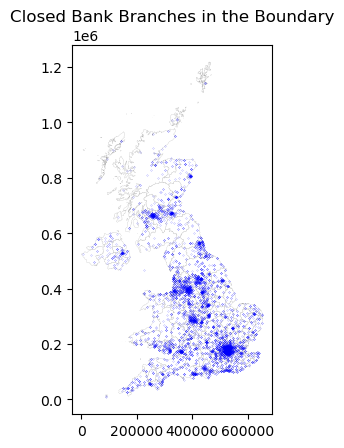

In [16]:
#Map all closed bank branches within UK boundary 

#Read UK boundary shapefile using gpd
UK_LAD_base = gpd.read_file('LAD_MAY_2024_UK_BUC.shp')

# Reproject into BNG 27700
closed_br_proj = closed_branches.to_crs(epsg=27700)

# Plot the UK LAD boundary using white fill color, grey edgecolor and linewidth of 0.1
UK_LAD_base_plot = UK_LAD_base.plot(color='white', edgecolor='grey', linewidth=0.1)

# Plot the reprojected closed bank branches on the same plot - ax=base_plot 
closed_br_proj.plot(ax=UK_LAD_base_plot, marker='o', color='blue', markersize=0.01)  

# Add a title to the plot
plt.title("Closed Bank Branches in the Boundary")

# Display the plot
plt.show()

In [17]:
# save the projected shapefile - all closed bank branches
closed_br_proj.to_file('closed_branches_all_27700.shp')

**Hypothesis testing: Quadrat-based Statistics for Closed Branches all years across UK**

In [18]:
# Open the projected closed branches shapefile
f = lps.io.open('closed_branches_all_27700.shp')

# Extract points and create a PointPattern object
pp_closed_br = PointPattern(np.asarray([pnt for pnt in f]))

# Close the shapefile
f.close()

# Print a summary of the point pattern
pp_closed_br.summary()

Point Pattern
5611 points
Bounding rectangle [(5615.327228760172,10561.990540796149), (652658.0183130404,1141494.0062196406)]
Area of window: 731761294858.2089
Intensity estimate for window: 7.667801015749577e-09
               x              y
0  146477.883243  529839.202997
1  142308.607781  527103.299615
2  163498.606160  535662.289327
3  161403.717328  528222.267378
4  138322.425252  520418.887820


In [19]:
# number of closed branches if within minimum bounding box window
pp_closed_br.lambda_mbb

7.667801015749579e-09

1.0952776452593739e-08

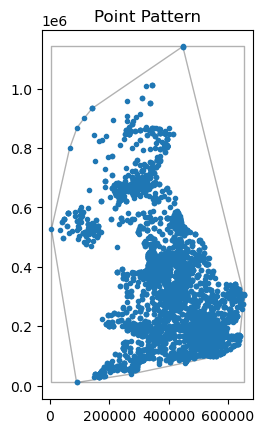

In [20]:
#convex hull
pp_closed_br.plot(window=True, hull=True)

# number of closed branches if within convex hull window
pp_closed_br.lambda_hull

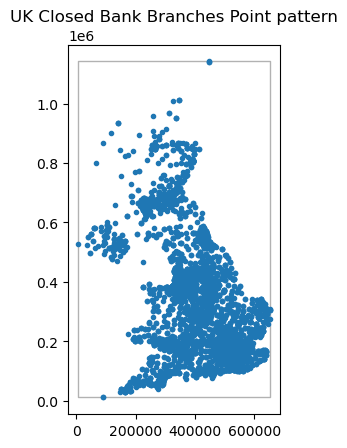

In [21]:
pp_closed_br.plot(window= True, title= "UK Closed Bank Branches Point pattern")

<Axes: title={'center': 'Quadrat Count'}>

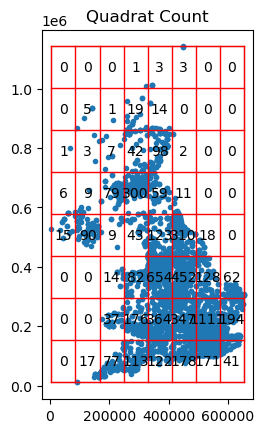

In [22]:
#Qstatistic using Rectangle window testing

q_r_closed_br = qs.QStatistic(pp_closed_br,shape= "rectangle",nx = 8, ny = 8)
q_r_closed_br.plot()

In [23]:
print('Chi-squared test statistic for the observed point pattern is: '+ str(q_r_closed_br.chi2)) 
print('Degree of freedom is: '+str(q_r_closed_br.df)) 
print('P-values for Chi-squared test statistic is: '+str.format('{0:.6f}', q_r_closed_br.chi2_pvalue)) # 6 decimals

Chi-squared test statistic for the observed point pattern is: 23436.54803065407
Degree of freedom is: 63
P-values for Chi-squared test statistic is: 0.000000


In [24]:
#Since the p-value is 0.00000 much smaller than 0.05, we reject the null hypothesis of CSR, and think the point pattern for UK closed branches is not random.

**Kernel Density Estimation for closed branches all years across UK**

In [25]:
closed_branches

,id,brand_full,brand_shor,branch_typ,region,postcode,long_wgs84,lat_wgs84,status,close_year,po_dist,geometry
3,4,Allied Irish Bank,AIB,Branch,Northern Ireland,BT1 2AL,-5.926691,54.599923,Closed,2017.0,54,POINT (-5.92669 54.59992)
5,6,Allied Irish Bank,AIB,Branch,Northern Ireland,BT11 9BY,-5.988669,54.573287,Closed,2017.0,371,POINT (-5.98867 54.57329)
6,7,Allied Irish Bank,AIB,Branch,Northern Ireland,BT20 4BA,-5.668490,54.660400,Closed,2021.0,47,POINT (-5.66849 54.66040)
7,8,Allied Irish Bank,AIB,Branch,Northern Ireland,BT23 7HS,-5.694836,54.592691,Closed,2017.0,203,POINT (-5.69484 54.59269)
8,9,Allied Irish Bank,AIB,Branch,Northern Ireland,BT28 1AG,-6.044236,54.511319,Closed,2021.0,247,POINT (-6.04424 54.51132)
...,...,...,...,...,...,...,...,...,...,...,...,...
10614,10647,Virgin Money,VM,Branch,Scotland,PA31 8LL,-5.435720,56.036790,Closed,2023.0,264,POINT (-5.43572 56.03679)
10619,10656,Virgin Money,VM,Branch,Scotland,DG8 6NL,-4.483220,54.959530,Closed,2023.0,219,POINT (-4.48322 54.95953)
10635,10683,Virgin Money,VM,Branch,South West,SN1 1PW,-1.782130,51.558600,Closed,2023.0,315,POINT (-1.78213 51.55860)
10644,10700,Virgin Money,VM,Branch,Scotland,AB53 4AA,-2.460170,57.537290,Closed,2023.0,141,POINT (-2.46017 57.53729)


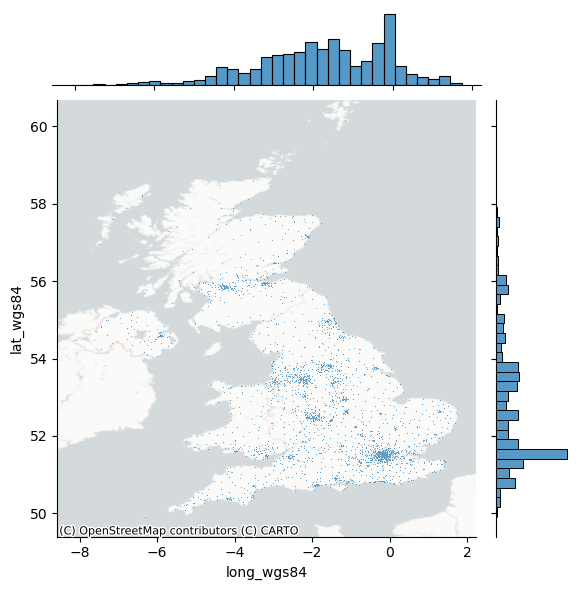

In [26]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x="long_wgs84", y="lat_wgs84", data=closed_branches, s=0.5
)
# Add basemap using contextily
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

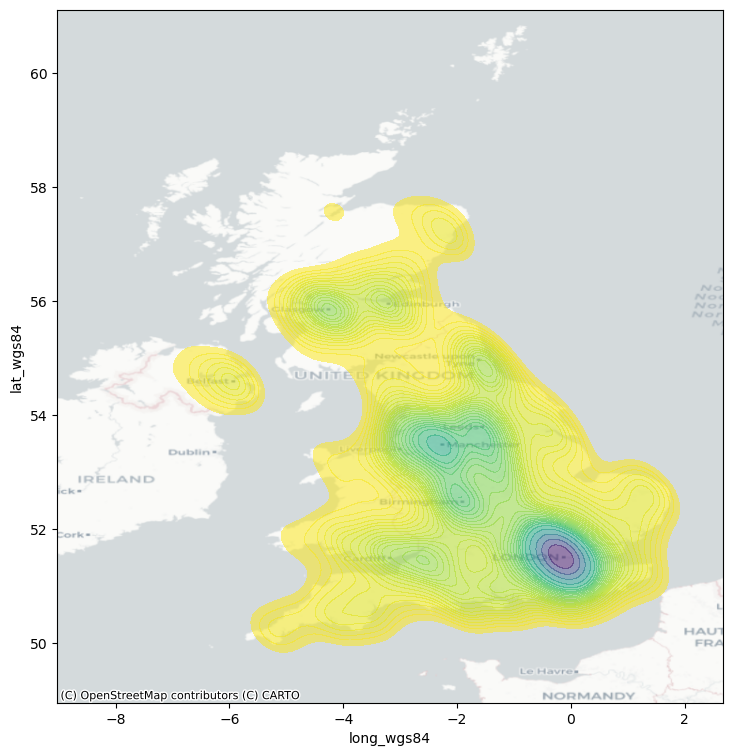

In [27]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Generate and add KDE with a shading of 30 gradients
# coloured contours, 55% of transparency,
# and the reverse viridis colormap

sns.kdeplot(
    x="long_wgs84",
    y="lat_wgs84",
    data=closed_branches,
    n_levels=30,
    bw_adjust=0.8,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, crs="EPSG:4326", source=contextily.providers.CartoDB.Positron
)

**Spatial Join**

In [28]:
UK_LAD_base.head()

,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,E06000001,Hartlepool,None,447161,531473,-1.27017,54.6761,3f58aa35-9ea6-4001-a80f-8aab0e41313f,"POLYGON ((448964.105 536757.184, 448986.025 53..."
1,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.5447,c5bc1c3e-111f-46db-8e41-362fbbc78d30,"POLYGON ((451894.299 521145.303, 453997.697 51..."
2,E06000003,Redcar and Cleveland,None,464330,519596,-1.00656,54.5675,29afa1cb-8719-44c2-9906-38bc7bae2981,"POLYGON ((478232.947 518788.803, 477689.303 51..."
3,E06000004,Stockton-on-Tees,None,444940,518179,-1.30664,54.5569,8ebb86c0-86bb-466e-ae7e-a832eeb755ff,"POLYGON ((452243.536 526335.188, 451711.300 52..."
4,E06000005,Darlington,None,428029,515648,-1.56835,54.5353,bf2173db-02e1-4b58-9617-e775100f58ec,"POLYGON ((436388.002 522354.197, 437351.702 52..."


In [29]:
# closed_br_proj crs=27700

# spatial join 
closed_br_uklad = gpd.sjoin(closed_br_proj, UK_LAD_base, how='inner', predicate='within') 

# print out the numbers of rows and columns
print("closed_br_uklad has {0} rows, {1} columns".format(closed_br_uklad.shape[0], closed_br_uklad.shape[1]))

closed_br_uklad has 5573 rows, 21 columns


In [30]:
# calculating total number of closed branches per lad
# Count occurrences of each LAD24NM
uklad_counts = closed_br_uklad['LAD24NM'].value_counts().astype(int)

# Convert the Series to a DataFrame
closed_br_uklad_count = pd.DataFrame(uklad_counts).reset_index()

# Rename the columns for better understanding
closed_br_uklad_count.columns = ['LAD24NM', 'Count']

# Display the resulting DataFrame
print(closed_br_uklad_count) # complete the code here

closed_br_uklad_count.head(4)

             LAD24NM  Count
0    North Yorkshire     86
1              Leeds     85
2         Birmingham     78
3        Westminster     72
4           Cornwall     64
..               ...    ...
356          Gosport      2
357         Bolsover      1
358  Isles of Scilly      1
359           Boston      1
360   Merthyr Tydfil      1

[361 rows x 2 columns]


,LAD24NM,Count
0,North Yorkshire,86
1,Leeds,85
2,Birmingham,78
3,Westminster,72


In [31]:
# add a new column of closed branches count in each LAD 
# join LAD and closed branches through attribute join (merge)
join_uklad_closedbr_count = UK_LAD_base.merge(closed_br_uklad_count, on="LAD24NM")

# save this newly joined .csv file into .shp file
join_uklad_closedbr_count.to_file(driver='ESRI Shapefile', filename='join_uklad_closedbr_count.shp')

In [32]:
# Calculate the area of each geometry 
join_uklad_closedbr_count['area_m2'] = join_uklad_closedbr_count.geometry.area #area m2
join_uklad_closedbr_count['area_km2'] = join_uklad_closedbr_count.geometry.area / 1e6  # Convert area from m² to km²

# Calculate density (e.g., population density per 100,000 square units)
join_uklad_closedbr_count['density_closedbr_100000m2'] = join_uklad_closedbr_count.apply(lambda row: 100000 * row.Count / row.area_m2, axis=1) #density per 100000m2
join_uklad_closedbr_count['density_closedbr_100km2'] = join_uklad_closedbr_count.apply(lambda row: 100 * row.Count / row.area_km2, axis=1) #density per 100km2

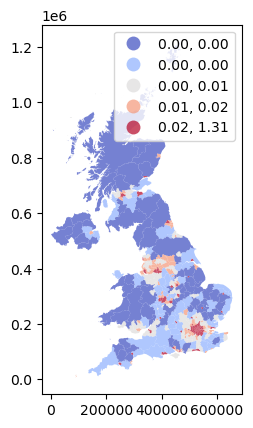

In [33]:
# Plot the density map
join_uklad_closedbr_count.plot(column='density_closedbr_100000m2', cmap='coolwarm', scheme='quantiles', alpha=0.7, legend=True)

# Show the plot
plt.show()

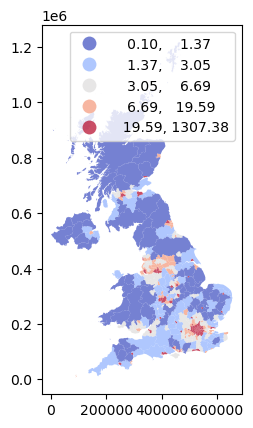

In [34]:
# Plot the density map
join_uklad_closedbr_count.plot(column='density_closedbr_100km2', cmap='coolwarm', scheme='quantiles', alpha=0.7, legend=True)

# Show the plot
plt.show()

**Distance-based Method: Centrography Analysis**

In [35]:
#Read UK 2022 LAD-level est. population data

uk_pop_lad22 = pd.read_csv("uk_pop_lad_2022.csv")

# Drop columns where all values are blank (NaN)
uk_pop_lad22 = uk_pop_lad22.dropna(axis=1, how="all")

# Specify the columns to remove commas from
columns_to_clean = ["estpop_22", "estpop22_km2", "estpop_2011", "estpop11_km2"]

# Remove commas from the specified columns
for column in columns_to_clean:
    uk_pop_lad22[column] = uk_pop_lad22[column].str.replace(",", "")  # Replace commas with empty string

#Convert numeric columns to numeric types
columns_to_convert = ["estpop_22", "estpop22_km2", "estpop_2011", "estpop11_km2"]

# Apply pd.to_numeric to selected columns
uk_pop_lad22[columns_to_convert] = uk_pop_lad22[columns_to_convert].apply(pd.to_numeric)


# Inspect the cleaned DataFrame
print(uk_pop_lad22.head())  # Display the first few rows of the cleaned DataFrame
print(uk_pop_lad22.info())  # Check column information after cleanup

#Save the cleaned DataFrame back to a CSV file
uk_pop_lad22.to_csv("uk_pop_lad22.csv", index=False)

          LAD24NM  estpop_22  estpop22_km2  estpop_2011  estpop11_km2
0   County Durham     528127           237       512994           230
1      Darlington     109469           554       105584           535
2      Hartlepool      93861          1002        92088           983
3   Middlesbrough     148285          2752       138368          2568
4  Northumberland     324362            65       316278            63
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LAD24NM       361 non-null    object
 1   estpop_22     361 non-null    int64 
 2   estpop22_km2  361 non-null    int64 
 3   estpop_2011   361 non-null    int64 
 4   estpop11_km2  361 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.2+ KB
None


In [36]:
#Merge UK LAD-level 2022 est. population size data to LAD gdf

uklad_base_pop22 = UK_LAD_base.merge(uk_pop_lad22, on="LAD24NM")
uklad_base_pop22

# save into .shp file
uklad_base_pop22.to_file(driver='ESRI Shapefile', filename='uklad_base_pop22.shp')

In [37]:
# spatial join UK LADs with closed branches points gdf to assign population
uklad_clbr_pop22 = gpd.sjoin(closed_br_proj, uklad_base_pop22, how='inner', predicate='within') 

# save into .shp file
uklad_clbr_pop22.to_file(driver='ESRI Shapefile', filename='uklad_closedbranches_pop22.shp')

In [38]:
# Open the projected closed branches UK LAD pop22 shapefile
clbr_ladpop22 = lps.io.open('uklad_closedbranches_pop22.shp')

# Extract points and create a PointPattern object
pp_clbr_ladpop22 = PointPattern(np.asarray([pnt for pnt in clbr_ladpop22]))

# Close the shapefile
#clbr_ladpop22.close()

# Print a summary of the point pattern
pp_clbr_ladpop22.summary()

Point Pattern
5573 points
Bounding rectangle [(5615.327228760172,10561.990540796149), (652658.0183130404,1141409.3754792984)]
Area of window: 731706535156.2294
Intensity estimate for window: 7.616441472413648e-09
               x              y
0  146477.883243  529839.202997
1  142308.607781  527103.299615
2  163498.606160  535662.289327
3  161403.717328  528222.267378
4  138322.425252  520418.887820


In [39]:
# Calculate the mean center for the point events
mc_clbr = mean_center(pp_clbr_ladpop22.points)

# Calculate the weighted mean center for the point events using generated weights
# Generate a sequence of weights based on UK LAD-level pop22 for each point
weights_ladpop22 = uklad_clbr_pop22["estpop_22"].values  # Convert to NumPy array
wmc_clbr = weighted_mean_center(pp_clbr_ladpop22.points, weights_ladpop22)

# Calculate the Manhattan Median for the point events
mm_clbr = manhattan_median(pp_clbr_ladpop22.points)

# Calculate the Euclidean Median for the point events
em_clbr = euclidean_median(pp_clbr_ladpop22.points)

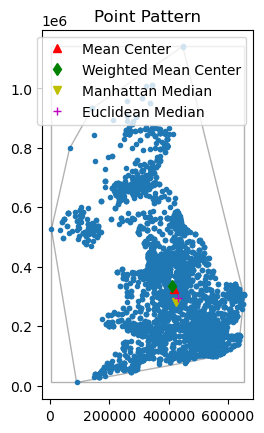

In [40]:
# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and convex hull
# 'window=True' includes the MBR in the plot
# 'hull=True' includes the convex hull in the plot
pp_clbr_ladpop22.plot(window=True, hull=True)

# Plot the mean center on the same plot
# 'mc_sta[0]' and 'mc_sta[1]' are the x and y coordinates of the mean center, respectively
# 'r^' indicates a red upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
plt.plot(mc_clbr[0], mc_clbr[1], 'r^', label='Mean Center') # complete the code

# Plot the weighted mean center on the same plot
# 'wmc_sta[0]' and 'wmc_sta[1]' are the x and y coordinates of the weighted mean center, respectively
# 'gd' indicates a green diamond marker
# 'label='Weighted Mean Center'' adds a label for this marker in the legend
plt.plot(wmc_clbr[0], wmc_clbr[1], 'gd', label='Weighted Mean Center') # complete the code

# Plot the Manhattan Median on the same plot
# 'mm_sta[0]' and 'mm_sta[1]' are the x and y coordinates of the Manhattan Median, respectively
# 'yv' indicates a yellow downward-pointing triangle marker
# 'label='Manhattan Median'' adds a label for this marker in the legend
plt.plot(mm_clbr[0], mm_clbr[1], 'yv', label='Manhattan Median') # complete the code

# Plot the Euclidean Median on the same plot
# 'em_sta[0]' and 'em_sta[1]' are the x and y coordinates of the Euclidean Median, respectively
# 'm+' indicates a magenta plus marker
# 'label='Euclidean Median'' adds a label for this marker in the legend
plt.plot(em_clbr[0], em_clbr[1], 'm+', label='Euclidean Median')

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1)

# Show the plot
# This command will display the plot with the point pattern, mean center, weighted mean center, Manhattan Median, and Euclidean Median
# your code here
plt.show()

In [41]:
#print the spatial descriptive statistics of the point coordinates 
print("Mean Centre for UK bank branch closures is: " + "(" + str(mc_clbr[0]) +" , " + str(mc_clbr[1])+ ")")
print("Weighted Mean Center for UK bank branch closures is: " + "(" + str(wmc_clbr[0]) +" , " + str(wmc_clbr[1])+ ")")
print("Manhattan Median for UK bank branch closures is: " + "(" + str(mm_clbr[0]) +" , " + str(mm_clbr[1])+ ")")
print("Euclidean Median for UK bank branch closures is: " + "(" + str(em_clbr[0]) +" , " + str(em_clbr[1])+ ")")

Mean Centre for UK bank branch closures is: (417974.1023816454 , 323936.93761488004)
Weighted Mean Center for UK bank branch closures is: (411156.3848076558 , 334069.00097129354)
Manhattan Median for UK bank branch closures is: (423751.39288218156 , 281588.8214769373)
Euclidean Median for UK bank branch closures is: (430996.94189398823 , 294621.2629926957)


In [42]:
#38 points were removed from analysis as these did not match LAD geometries via inner spatial join

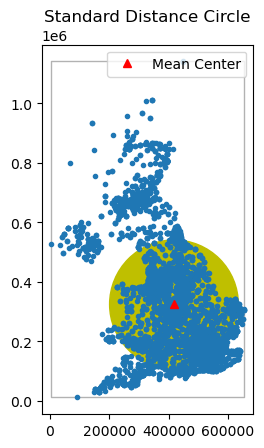

In [43]:
#Standard distance circle

# Calculate the standard distance for a series of point events based on their (x, y) coordinates.
# Standard distance is a measure of the dispersion of points around their mean center.
stdd_clbr = std_distance(pp_clbr_ladpop22.points)

# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and get the axis object
# 'get_ax=True' returns the axis object for further customization
# 'title='Standard Distance Circle'' sets the plot title
# 'window=True' includes the MBR in the plot
ax = pp_clbr_ladpop22.plot(get_ax=True, title='Standard Distance Circle', window=True)

# Plot the mean center on the same plot
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'r^' indicates a red upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
# your code here
plt.plot(mc_clbr[0], mc_clbr[1], 'r^', label='Mean Center')

# Create a circle centered at the mean center with a radius equal to the standard distance
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'stdd_clbr' is the standard distance
# 'color='y'' specifies the color yellow for the circle
circle = plt.Circle((mc_clbr[0], mc_clbr[1]), stdd_clbr, color='y', fill=True)
ax.add_artist(circle)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1)

# Show the plot
# This command will display the plot with the point pattern, mean center, and standard distance circle
plt.show()

<Figure size 640x480 with 0 Axes>

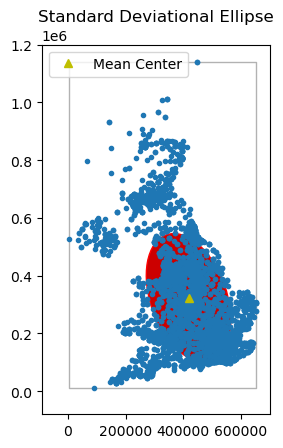

In [44]:
#Standard deviational ellipse 

# Import necessary libraries
from matplotlib.patches import Ellipse
from pylab import figure, show

# Calculate the parameters of the standard deviational ellipse for a series of point events based on their (x, y) coordinates.
# The ellipse function returns the semi-major axis (sx), semi-minor axis (sy), and the orientation angle (theta) of the ellipse.
sx, sy, theta = ellipse(pp_clbr_ladpop22.points)

# Convert the orientation angle `theta` from radians to degrees
# The `np.degrees` function converts an angle from radians to degrees
theta_degree = np.degrees(theta) # your code here

# Create a figure for the plot
fig = figure()

# Calculate the mean center for the point events
mc_clbr = mean_center(pp_clbr_ladpop22.points)

# Create an ellipse centered at the mean center with the specified width, height, and rotation angle
# 'xy=mean_center(pp_clbr_ladpop22.points)' sets the center of the ellipse at the mean center of the points
# 'width=sx*2' sets the width of the ellipse to twice the semi-major axis length
# 'height=sy*2' sets the height of the ellipse to twice the semi-minor axis length
# 'angle=-theta_degree' sets the rotation angle of the ellipse (negative for clockwise rotation)
e = Ellipse(xy=mc_clbr, width=sx*2, height=sy*2, angle=-theta_degree) 

# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and get the axis object
# 'get_ax=True' returns the axis object for further customization
# 'title='Standard Deviational Ellipse'' sets the plot title
# 'window=True' includes the MBR in the plot
ax = pp_clbr_ladpop22.plot(get_ax=True, title='Standard Deviational Ellipse', window=True)

# Add the ellipse to the plot
ax.add_artist(e)

# Set the clipping box for the ellipse to match the axis bounding box
e.set_clip_box(ax.bbox)

# Set the face color of the ellipse (e.g., a lighter red color)
e.set_facecolor([0.8, 0, 0])

# Set the edge color of the ellipse (e.g., red)
e.set_edgecolor([1, 0, 0])

# Set the limits for the x and y axes
ax.set_xlim(-90000, 700000)
ax.set_ylim(-80000, 1200000)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Plot the mean center on the same plot
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'y^' indicates a yellow upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
plt.plot(mc_clbr[0], mc_clbr[1], 'y^', label='Mean Center')

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1)

# Show the plot
# This command will display the plot with the point pattern, mean center, and standard deviational ellipse
plt.show()

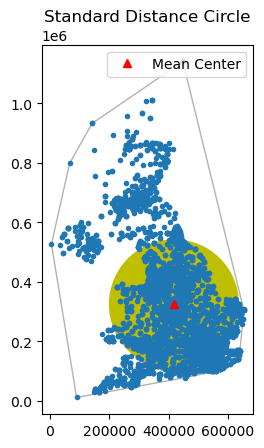

In [45]:
#Standard distance circle

# Calculate the standard distance for a series of point events based on their (x, y) coordinates.
# Standard distance is a measure of the dispersion of points around their mean center.
stdd_clbr = std_distance(pp_clbr_ladpop22.points)

# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and get the axis object
# 'get_ax=True' returns the axis object for further customization
# 'title='Standard Distance Circle'' sets the plot title
# 'window=True' includes the MBR in the plot
ax = pp_clbr_ladpop22.plot(get_ax=True, title='Standard Distance Circle', hull=True)

# Plot the mean center on the same plot
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'r^' indicates a red upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
# your code here
plt.plot(mc_clbr[0], mc_clbr[1], 'r^', label='Mean Center')

# Create a circle centered at the mean center with a radius equal to the standard distance
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'stdd_clbr' is the standard distance
# 'color='y'' specifies the color yellow for the circle
circle = plt.Circle((mc_clbr[0], mc_clbr[1]), stdd_clbr, color='y', fill=True)
ax.add_artist(circle)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1)

# Show the plot
# This command will display the plot with the point pattern, mean center, and standard distance circle
plt.show()

<Figure size 640x480 with 0 Axes>

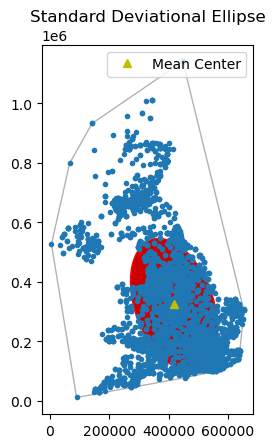

In [46]:
#Standard deviational ellipse 

# Import necessary libraries
from matplotlib.patches import Ellipse
from pylab import figure, show

# Calculate the parameters of the standard deviational ellipse for a series of point events based on their (x, y) coordinates.
# The ellipse function returns the semi-major axis (sx), semi-minor axis (sy), and the orientation angle (theta) of the ellipse.
sx, sy, theta = ellipse(pp_clbr_ladpop22.points)

# Convert the orientation angle `theta` from radians to degrees
# The `np.degrees` function converts an angle from radians to degrees
theta_degree = np.degrees(theta) # your code here

# Create a figure for the plot
fig = figure()

# Calculate the mean center for the point events
mc_clbr = mean_center(pp_clbr_ladpop22.points)

# Create an ellipse centered at the mean center with the specified width, height, and rotation angle
# 'xy=mean_center(pp_clbr_ladpop22.points)' sets the center of the ellipse at the mean center of the points
# 'width=sx*2' sets the width of the ellipse to twice the semi-major axis length
# 'height=sy*2' sets the height of the ellipse to twice the semi-minor axis length
# 'angle=-theta_degree' sets the rotation angle of the ellipse (negative for clockwise rotation)
e = Ellipse(xy=mc_clbr, width=sx*2, height=sy*2, angle=-theta_degree) 

# Plot the point pattern 'pp_clbr_ladpop22' along with its Minimum Bounding Rectangle (MBR) and get the axis object
# 'get_ax=True' returns the axis object for further customization
# 'title='Standard Deviational Ellipse'' sets the plot title
# 'window=True' includes the MBR in the plot
ax = pp_clbr_ladpop22.plot(get_ax=True, title='Standard Deviational Ellipse', hull=True)

# Add the ellipse to the plot
ax.add_artist(e)

# Set the clipping box for the ellipse to match the axis bounding box
e.set_clip_box(ax.bbox)

# Set the face color of the ellipse (e.g., a lighter red color)
e.set_facecolor([0.8, 0, 0])

# Set the edge color of the ellipse (e.g., red)
e.set_edgecolor([1, 0, 0])


# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

# Plot the mean center on the same plot
# 'mc_clbr[0]' and 'mc_clbr[1]' are the x and y coordinates of the mean center, respectively
# 'y^' indicates a yellow upward-pointing triangle marker
# 'label='Mean Center'' adds a label for this marker in the legend
plt.plot(mc_clbr[0], mc_clbr[1], 'y^', label='Mean Center')

# Add a legend to the plot
# 'numpoints=1' specifies that each legend entry will show a single point
plt.legend(numpoints=1)

# Show the plot
# This command will display the plot with the point pattern, mean center, and standard deviational ellipse
plt.show()

**Distance-based Method: Mean Nearest Neighbor Distance Statistics and K-function**

In [47]:
pp_clbr_ladpop22.mean_nnd # mean nearest neighbor distance

971.5999689470534

In [48]:
pp_clbr_ladpop22.nnd # Nearest neighbor distances

array([[1.23364882e+02],
       [1.32196251e+03],
       [7.94602525e+01],
       ...,
       [3.49167925e+01],
       [2.64100062e-01],
       [1.43432430e+03]])

In [49]:
uklad_clbr_pop22

,id,brand_full,brand_shor,branch_typ,region,postcode,long_wgs84,lat_wgs84,status,close_year,...,LAD24NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,estpop_22,estpop22_km2,estpop_2011,estpop11_km2
3,4,Allied Irish Bank,AIB,Branch,Northern Ireland,BT1 2AL,-5.926691,54.599923,Closed,2017.0,...,None,146465,529747,-5.92535,54.5985,e67d37f9-e23c-4159-a7a2-14bcf457e488,348005,2617,333895,2511
5,6,Allied Irish Bank,AIB,Branch,Northern Ireland,BT11 9BY,-5.988669,54.573287,Closed,2017.0,...,None,146465,529747,-5.92535,54.5985,e67d37f9-e23c-4159-a7a2-14bcf457e488,348005,2617,333895,2511
6,7,Allied Irish Bank,AIB,Branch,Northern Ireland,BT20 4BA,-5.668490,54.660400,Closed,2021.0,...,None,164321,524944,-5.64568,54.5641,46a86327-cf5e-452c-9ed6-fbf7dd4defdf,164223,358,156943,342
7,8,Allied Irish Bank,AIB,Branch,Northern Ireland,BT23 7HS,-5.694836,54.592691,Closed,2017.0,...,None,164321,524944,-5.64568,54.5641,46a86327-cf5e-452c-9ed6-fbf7dd4defdf,164223,358,156943,342
8,9,Allied Irish Bank,AIB,Branch,Northern Ireland,BT28 1AG,-6.044236,54.511319,Closed,2021.0,...,None,138712,518920,-6.03545,54.4975,df70e5be-8043-46cc-bf02-a62101c4a874,149915,298,135280,269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10614,10647,Virgin Money,VM,Branch,Scotland,PA31 8LL,-5.435720,56.036790,Closed,2023.0,...,None,200740,715443,-5.22114,56.2894,8a707e27-de3c-4b6e-8ba3-1cf6cbaa9598,87920,13,88930,13
10619,10656,Virgin Money,VM,Branch,Scotland,DG8 6NL,-4.483220,54.959530,Closed,2023.0,...,None,270645,579856,-4.02863,55.0962,96412da5-5e3a-4bd7-8b86-3be7bec42d24,145770,23,151410,24
10635,10683,Virgin Money,VM,Branch,South West,SN1 1PW,-1.782130,51.558600,Closed,2023.0,...,None,418550,186565,-1.73369,51.5776,ae777cb6-9f5d-4027-b1c7-9a99a65a0a5e,235657,1024,209709,911
10644,10700,Virgin Money,VM,Branch,Scotland,AB53 4AA,-2.460170,57.537290,Closed,2023.0,...,None,352284,816277,-2.79208,57.2347,070287eb-0f6b-4b63-ae30-cfd9e58d7e9c,263750,42,253650,40


In [49]:
# Import the distance_statistics module from the pointpats library
from pointpats import distance_statistics

# Extract the Longitude and Latitude columns from the GeoDataFrame (gdf) and store them in pp_coords
# This step ensures we are working with the coordinates directly, rather than using the pointpattern
pp_coords = uklad_clbr_pop22[['BNG_E', 'BNG_N']]

# Take a random sample of 25% of the points from pp_coords to create a test dataset (pp_test)
# This sampling is done to reduce the processing time for the distance statistics calculations
pp_test = pp_coords.sample(frac=0.25)

# Perform the K-function test on the sampled points (pp_test) using the k_test function from distance_statistics
# The keep_simulations=True parameter indicates that the simulation results should be retained
k = distance_statistics.k_test(pp_test, keep_simulations=True)

In [50]:
# Get the distance values (d) used to compute the distance statistic.b
k.support

array([     0.        ,   8644.76549222,  17289.53098444,  25934.29647667,
        34579.06196889,  43223.82746111,  51868.59295333,  60513.35844555,
        69158.12393778,  77802.88943   ,  86447.65492222,  95092.42041444,
       103737.18590666, 112381.95139889, 121026.71689111, 129671.48238333,
       138316.24787555, 146961.01336777, 155605.77886   , 164250.54435222])

In [51]:
# Get the statistic
k.statistic

array([0.00000000e+00, 4.42898781e+09, 1.04107966e+10, 1.74181092e+10,
       2.44658475e+10, 3.25182824e+10, 4.07734401e+10, 5.05939031e+10,
       5.99292582e+10, 6.97491267e+10, 8.09351448e+10, 9.19130896e+10,
       1.02470726e+11, 1.13685280e+11, 1.24101427e+11, 1.34811849e+11,
       1.46288575e+11, 1.59203979e+11, 1.71780521e+11, 1.84478340e+11])

In [52]:
# Get the p-value
k.pvalue

array([0.    , 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001])

In [53]:
# Get the simulated values under random process
k.simulations.T

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.28405623e+08, 2.42252620e+08, 2.32550840e+08, ...,
        2.25578497e+08, 2.54893041e+08, 2.07592589e+08],
       [8.76840288e+08, 9.32197582e+08, 9.59272213e+08, ...,
        9.28365048e+08, 9.23542691e+08, 9.31794165e+08],
       ...,
       [5.64986522e+10, 5.67660827e+10, 5.67975764e+10, ...,
        5.75509361e+10, 5.67409692e+10, 5.75316170e+10],
       [6.24763536e+10, 6.28639612e+10, 6.30183113e+10, ...,
        6.38280574e+10, 6.29004891e+10, 6.37647328e+10],
       [6.88361154e+10, 6.92800931e+10, 6.95611766e+10, ...,
        7.03497035e+10, 6.94796934e+10, 7.03133893e+10]])

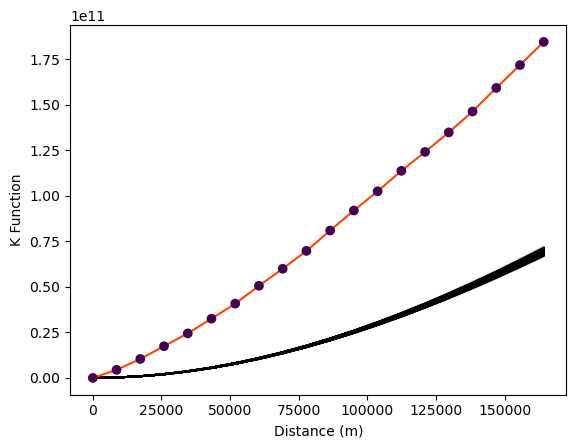

In [55]:
# plot out the results

# Plot the simulation results as faint black lines
# k.support: The support values (distances)
# k.simulations.T: The transpose of the simulation results of the K-function
# color='k': Sets the color of the lines to black
# alpha=.01: Sets the transparency of the lines to 1%, making them very faint
plt.plot(k.support, k.simulations.T, color='k', alpha=.01)

# Plot the observed K-function statistic as an orange line
# k.support: The support values (distances)
# k.statistic: The observed K-function statistic
# color='orangered': Sets the color of the line to orangered
plt.plot(k.support, k.statistic, color='orangered')

# Plot the observed K-function statistic as scatter points
# k.support: The support values (distances)
# k.statistic: The observed K-function statistic
# cmap='viridis': Specifies the colormap to be used for coloring the points
# c=k.pvalue < .05: Colors the points based on their p-value, highlighting points with p-values less than 0.05 (significant clustering or dispersion)
# zorder=4: Ensures that these scatter points are plotted on top of other plot elements
plt.scatter(k.support, k.statistic, 
            cmap='viridis', c=k.pvalue < .05,
            zorder=4 # Make sure they plot on top
           )

# Set the label for the x-axis
plt.xlabel('Distance (m)')

# Set the label for the y-axis
plt.ylabel('K Function')

# Set the title of the plot
#plt.title('K Function Plot')

#save as file
plt.savefig("figures/kfunction1.png", dpi=300, bbox_inches='tight', facecolor='white')

# Display the plot
plt.show()